# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

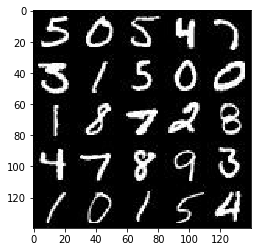

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

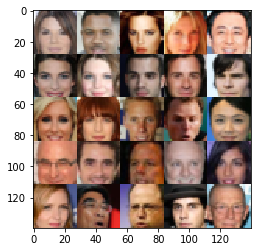

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    # TODO: Implement Function

    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(input, alpha=0.2, name='leaky_relu'):
    return tf.maximum(input, input * alpha, name=name)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # images is 28x28xN
        
        # 14x14x64
        c1 = tf.layers.conv2d(images, filters=128, kernel_size=5, strides=2, padding='same')
        c1 = leaky_relu(c1, alpha, name='c1_relu')
        
        # 7x7x128
        c2 = tf.layers.conv2d(c1, filters=256, kernel_size=5, strides=2, padding='same')
        c2 = tf.layers.batch_normalization(c2, training=True)
        c2 = leaky_relu(c2, alpha)
        
        # 4x4x256
        c3 = tf.layers.conv2d(c2, filters=512, kernel_size=5, strides=2, padding='same')
        c3 = tf.layers.batch_normalization(c3, training=True)
        c3 = leaky_relu(c3, alpha)
        c3.set_shape((None, 4, 4, 512))

        c3 = tf.reshape(c3, (-1, 4*4*512))
        logits = tf.layers.dense(c3, 1)
        out = tf.nn.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, output_dim, training=True):
    alpha = 0.2
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not training):
        # First fully connected layer
        h1 = tf.layers.dense(z, 7*7*512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=training)
        h1 = leaky_relu(h1, alpha)
        
        # 14 x 14 x 256
        c1 = tf.layers.conv2d_transpose(h1, filters=256, kernel_size=5, strides=2, padding='same')
        c1 = tf.layers.batch_normalization(c1, training=training)
        c1 = leaky_relu(c1, alpha)
        
        # 28 x 28 x 128
        c2 = tf.layers.conv2d_transpose(c1, filters=128, kernel_size=5, strides=2, padding='same')
        c2 = tf.layers.batch_normalization(c2, training=training)
        c2 = leaky_relu(c2, alpha)

        # 28 x 28 x 64
        c3 = tf.layers.conv2d_transpose(c2, filters=64, kernel_size=5, strides=1, padding='same')
        c3 = tf.layers.batch_normalization(c3, training=training)
        c3 = leaky_relu(c3, alpha)

        # 28 x 28 x output_dim
        c4 = tf.layers.conv2d_transpose(c3, filters=output_dim, kernel_size=5, strides=1, padding='same')
        c4.set_shape((None, 28, 28, output_dim))
        logits = c4

        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real, False)
    d_model_fake, d_logits_fake = discriminator(g_model, True)

    d_labels_real = tf.ones_like(d_logits_real) * 0.9
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real), name='d_loss_real')
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)), name='d_loss_fake')
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)), name='g_loss')

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print_every = 10
    show_every = 100
    show_size = 25
        
    _, w, h, c = data_shape
    input_real, input_z, lr = model_inputs(w, h, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, c)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    saver = tf.train.Saver()
    steps = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # from [-0.5,0.5] to [-1,1]
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_size, input_z, c, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 19.8841
Epoch 1/2... Discriminator Loss: 0.9419... Generator Loss: 2.0633
Epoch 1/2... Discriminator Loss: 2.6995... Generator Loss: 6.6476
Epoch 1/2... Discriminator Loss: 2.5638... Generator Loss: 0.2045
Epoch 1/2... Discriminator Loss: 3.1380... Generator Loss: 0.1093
Epoch 1/2... Discriminator Loss: 2.6307... Generator Loss: 0.1345
Epoch 1/2... Discriminator Loss: 2.3509... Generator Loss: 0.1718
Epoch 1/2... Discriminator Loss: 2.0304... Generator Loss: 0.2293
Epoch 1/2... Discriminator Loss: 1.9784... Generator Loss: 0.2600
Epoch 1/2... Discriminator Loss: 2.0808... Generator Loss: 0.2280


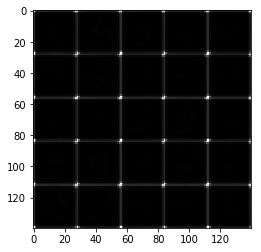

Epoch 1/2... Discriminator Loss: 1.9600... Generator Loss: 0.2553
Epoch 1/2... Discriminator Loss: 1.8657... Generator Loss: 0.3120
Epoch 1/2... Discriminator Loss: 1.7403... Generator Loss: 0.3358
Epoch 1/2... Discriminator Loss: 1.8454... Generator Loss: 0.2857
Epoch 1/2... Discriminator Loss: 1.7359... Generator Loss: 0.3410
Epoch 1/2... Discriminator Loss: 1.6371... Generator Loss: 0.4118
Epoch 1/2... Discriminator Loss: 1.7721... Generator Loss: 0.3206
Epoch 1/2... Discriminator Loss: 1.7465... Generator Loss: 0.3307
Epoch 1/2... Discriminator Loss: 1.7093... Generator Loss: 0.3263
Epoch 1/2... Discriminator Loss: 1.7001... Generator Loss: 0.3590


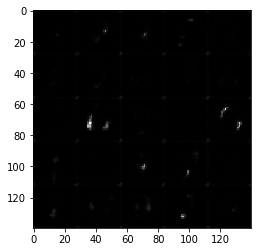

Epoch 1/2... Discriminator Loss: 1.7381... Generator Loss: 0.3438
Epoch 1/2... Discriminator Loss: 1.6245... Generator Loss: 0.3660
Epoch 1/2... Discriminator Loss: 1.6344... Generator Loss: 0.3658
Epoch 1/2... Discriminator Loss: 1.7729... Generator Loss: 0.3295
Epoch 1/2... Discriminator Loss: 1.5262... Generator Loss: 0.5125
Epoch 1/2... Discriminator Loss: 1.8283... Generator Loss: 0.3070
Epoch 1/2... Discriminator Loss: 1.6842... Generator Loss: 0.3594
Epoch 1/2... Discriminator Loss: 1.6435... Generator Loss: 0.4042
Epoch 1/2... Discriminator Loss: 1.6829... Generator Loss: 0.3918
Epoch 1/2... Discriminator Loss: 1.7660... Generator Loss: 0.3382


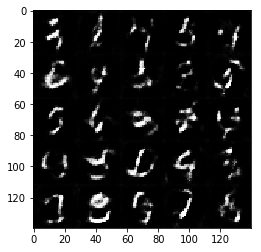

Epoch 1/2... Discriminator Loss: 1.5859... Generator Loss: 0.3968
Epoch 1/2... Discriminator Loss: 1.6368... Generator Loss: 0.3857
Epoch 1/2... Discriminator Loss: 1.6068... Generator Loss: 0.3983
Epoch 1/2... Discriminator Loss: 1.8746... Generator Loss: 0.2880
Epoch 1/2... Discriminator Loss: 1.6923... Generator Loss: 0.3502
Epoch 1/2... Discriminator Loss: 1.4640... Generator Loss: 0.4817
Epoch 1/2... Discriminator Loss: 1.5624... Generator Loss: 0.4407
Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 0.4323
Epoch 1/2... Discriminator Loss: 1.8825... Generator Loss: 0.2846
Epoch 1/2... Discriminator Loss: 1.6826... Generator Loss: 0.3557


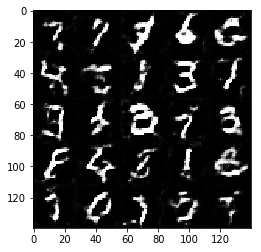

Epoch 1/2... Discriminator Loss: 1.9151... Generator Loss: 0.2654
Epoch 1/2... Discriminator Loss: 1.8454... Generator Loss: 0.2784
Epoch 1/2... Discriminator Loss: 1.5869... Generator Loss: 0.3901
Epoch 1/2... Discriminator Loss: 1.4108... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.5035
Epoch 1/2... Discriminator Loss: 1.7146... Generator Loss: 0.3192
Epoch 1/2... Discriminator Loss: 1.6312... Generator Loss: 0.4151
Epoch 1/2... Discriminator Loss: 1.6614... Generator Loss: 0.3921
Epoch 1/2... Discriminator Loss: 1.5907... Generator Loss: 0.4110
Epoch 1/2... Discriminator Loss: 1.7296... Generator Loss: 0.3640


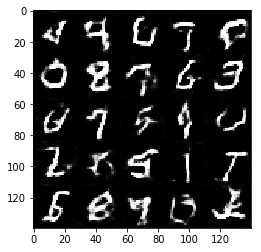

Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 1.1296
Epoch 1/2... Discriminator Loss: 1.5505... Generator Loss: 1.1809
Epoch 1/2... Discriminator Loss: 1.5906... Generator Loss: 1.6000
Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 1.1928
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 1.1780
Epoch 1/2... Discriminator Loss: 1.6170... Generator Loss: 0.4349
Epoch 1/2... Discriminator Loss: 1.6466... Generator Loss: 0.3754
Epoch 1/2... Discriminator Loss: 1.5841... Generator Loss: 0.3946
Epoch 1/2... Discriminator Loss: 1.4439... Generator Loss: 0.5137
Epoch 1/2... Discriminator Loss: 1.5552... Generator Loss: 0.4033


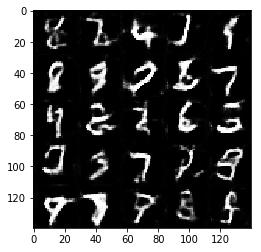

Epoch 1/2... Discriminator Loss: 1.6717... Generator Loss: 0.3858
Epoch 1/2... Discriminator Loss: 1.4946... Generator Loss: 0.4558
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.7381


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 4.0174
Epoch 1/1... Discriminator Loss: 0.5842... Generator Loss: 3.4456
Epoch 1/1... Discriminator Loss: 6.7441... Generator Loss: 0.0043
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 2.3678
Epoch 1/1... Discriminator Loss: 1.7352... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 2.4687
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 1.5593
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 1.7167
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.4088
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 2.8242


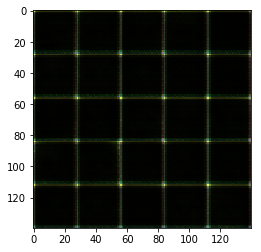

Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 2.8779
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 2.1236
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 3.4603
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.2842
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.8352
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 1.0062


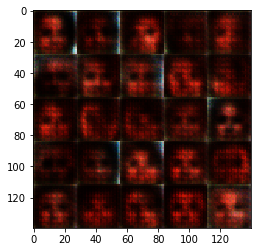

Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 2.4159
Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 3.2985
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 1.9712
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.5714
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 4.8535
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 1.9520
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.4969
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.5809


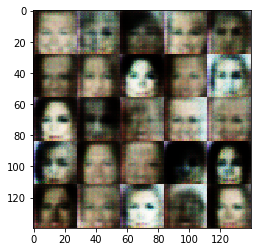

Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.4232
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 2.1944
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 2.3146
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.6227


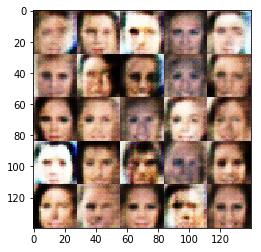

Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.5544
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 1.7384
Epoch 1/1... Discriminator Loss: 0.7409... Generator Loss: 2.1800
Epoch 1/1... Discriminator Loss: 1.8181... Generator Loss: 0.3558
Epoch 1/1... Discriminator Loss: 2.3939... Generator Loss: 0.2049
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.5983
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.3818


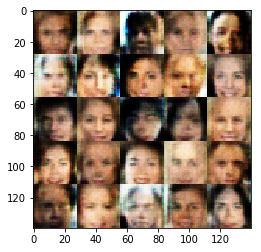

Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 2.0239
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.4604
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 2.3459
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.9177
Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 1.4846
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 1.9488


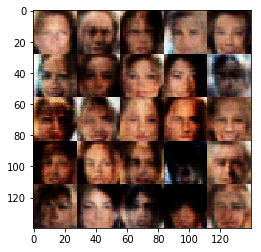

Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.6363
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.4452
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.6359
Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 2.3495
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 4.0838
Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 1.5985
Epoch 1/1... Discriminator Loss: 0.5654... Generator Loss: 2.6549
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.6259


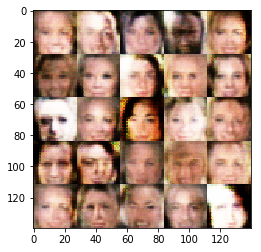

Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 1.6014
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.7882
Epoch 1/1... Discriminator Loss: 0.6863... Generator Loss: 2.0307
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 1.5810
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 3.3895
Epoch 1/1... Discriminator Loss: 2.2058... Generator Loss: 0.2176
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.5599
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.5822


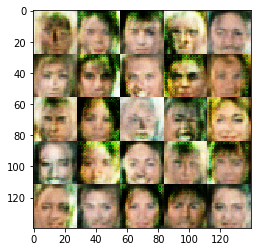

Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.1205
Epoch 1/1... Discriminator Loss: 1.6810... Generator Loss: 0.3585
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 2.3874
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 1.4229
Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 2.2692
Epoch 1/1... Discriminator Loss: 1.6975... Generator Loss: 0.4709


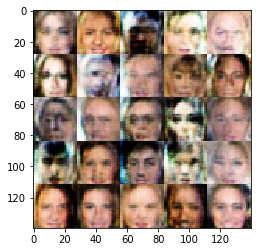

Epoch 1/1... Discriminator Loss: 0.5264... Generator Loss: 2.2094
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 0.6972... Generator Loss: 1.5190
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 2.2095
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.4803
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.0320


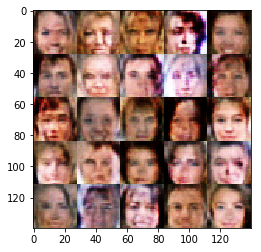

Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 2.4753
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.7604
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 3.0641
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.5482
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 3.3350
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.3653


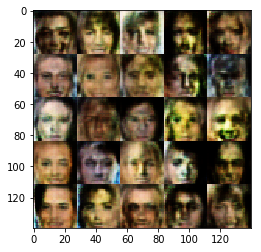

Epoch 1/1... Discriminator Loss: 0.4906... Generator Loss: 2.3039
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 1.8531
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 2.3743
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.4017
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 1.4763
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 1.0855


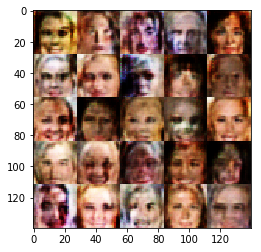

Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 1.7564
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.8898... Generator Loss: 0.3521
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 2.2505
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 1.2026
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.5474


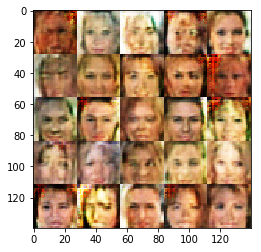

Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.1849
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 0.7959... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 2.1972


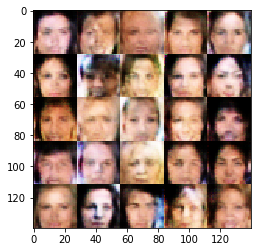

Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.7162... Generator Loss: 0.3742
Epoch 1/1... Discriminator Loss: 0.6369... Generator Loss: 2.2199
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 2.6746
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 2.5286
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 1.1426


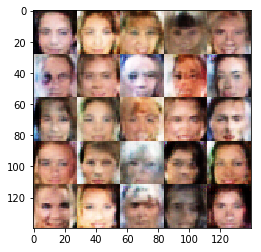

Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 1.8268
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 1.3990
Epoch 1/1... Discriminator Loss: 0.7909... Generator Loss: 1.4163
Epoch 1/1... Discriminator Loss: 4.7649... Generator Loss: 5.4853
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.3682
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 2.5207


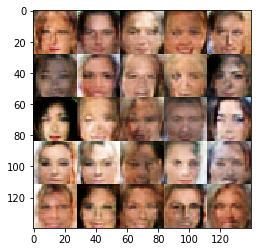

Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.2856
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.2491
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.5546
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.6738
Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 2.9733
Epoch 1/1... Discriminator Loss: 2.1324... Generator Loss: 0.2472
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7803


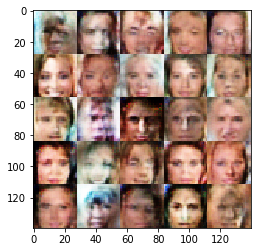

Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 0.7269... Generator Loss: 2.1822
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 0.7016... Generator Loss: 2.6142
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 0.5158... Generator Loss: 2.9944
Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 2.4668
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.6192
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.5487
Epoch 1/1... Discriminator Loss: 0.7325... Generator Loss: 1.2859


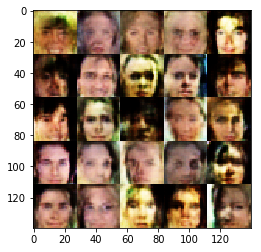

Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.4190
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 1.6537
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.9959... Generator Loss: 3.1794
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 1.9994
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 1.7589
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.4633


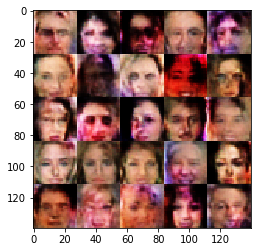

Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.6040
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 3.5270
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 1.7412


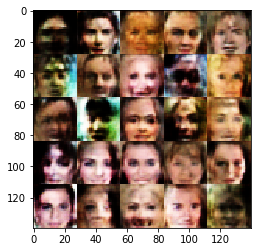

Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 1.1977
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.3508
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 3.7899
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 0.9654


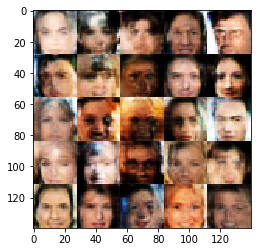

Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.2287
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 1.7862
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 1.3959
Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 2.0252
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 1.6438
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.7452
Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 2.3751


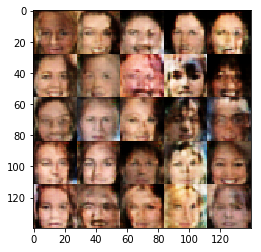

Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 1.5236
Epoch 1/1... Discriminator Loss: 0.7003... Generator Loss: 2.3208
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 2.1323
Epoch 1/1... Discriminator Loss: 2.0799... Generator Loss: 0.2699


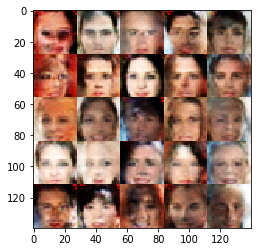

Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 1.4893
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 1.5014
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 2.1540
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.3727


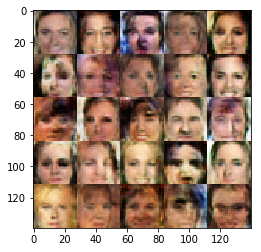

Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 0.7904... Generator Loss: 2.8658
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 1.3369
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 1.4496
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.5385
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.5224
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 1.2884


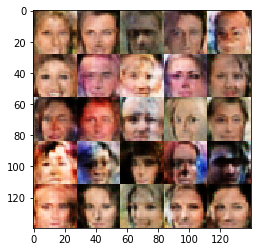

Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.2624
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 3.0843
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 0.3817


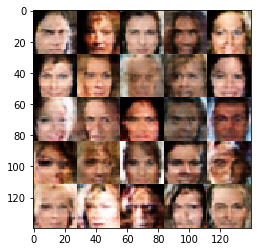

Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.2467
Epoch 1/1... Discriminator Loss: 0.7152... Generator Loss: 1.6849
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.1601
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 2.6826
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 0.6118... Generator Loss: 1.5648
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.0365


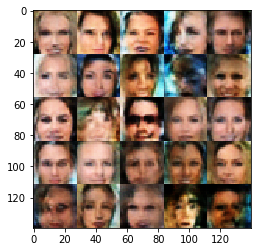

Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.2549
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 2.2401
Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 2.7502
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.7347
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 1.6422
Epoch 1/1... Discriminator Loss: 0.7921... Generator Loss: 1.2026
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 1.4712
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 1.5961


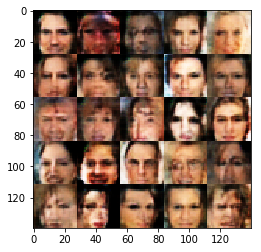

Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 1.5820
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 1.7047
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 1.5722
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 1.8430
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.9223
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.9142


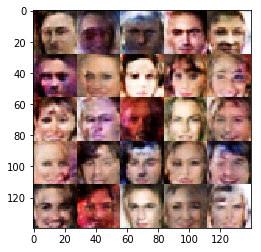

Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 0.4945... Generator Loss: 2.3787
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.5479
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.4703
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 2.1197
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 3.2448
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.3161


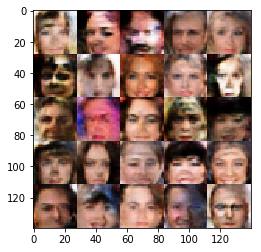

Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.8945
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.7840
Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 1.9086
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 1.5346
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 1.4270
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 1.6451


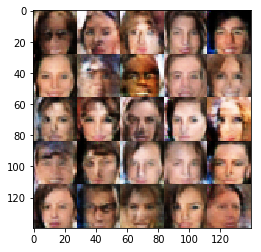

Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 2.1118
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 2.2049
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 1.6697
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 4.4322
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 2.1385


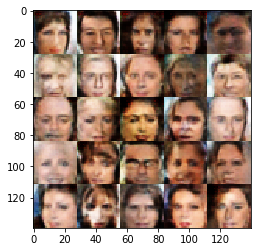

Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.7174
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 2.1869
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 1.5912... Generator Loss: 2.7235
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.2261
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.1077


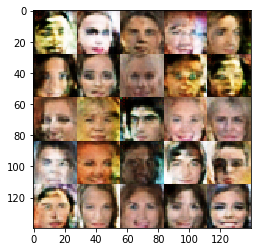

Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.4400
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.6202
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.5541
Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 1.7391


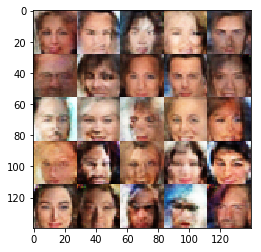

Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.3915
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 2.4268
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 1.1447
Epoch 1/1... Discriminator Loss: 0.7184... Generator Loss: 1.4234
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 0.5329... Generator Loss: 2.2996
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 1.1914
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.4074
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 2.8342


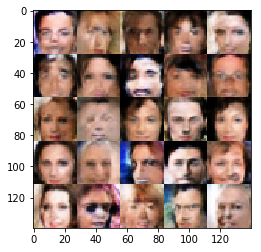

Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 1.1858
Epoch 1/1... Discriminator Loss: 0.5299... Generator Loss: 2.2074
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.3019
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.1179
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 1.5379
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.2633
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.8319
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 0.9826


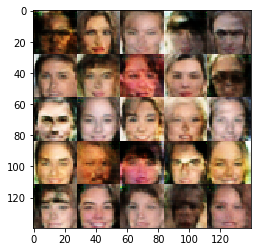

Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 1.4859
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 0.9820
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.4779
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.6362


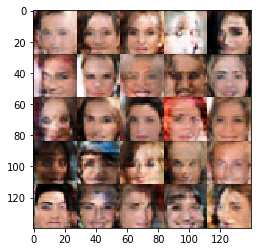

Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.8805
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 0.9625
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 1.5710
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.8592


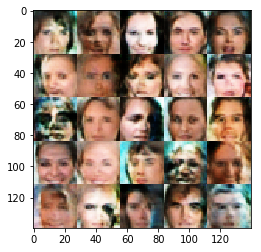

Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 1.0649
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.6084
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 2.4660
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 1.9169
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.6178
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.5844
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 1.1447


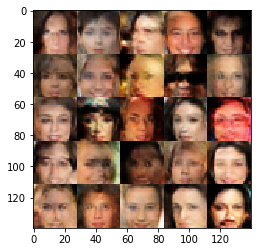

Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.4883
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.2535
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.6866


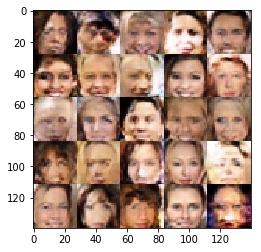

Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 2.1113
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 1.5831


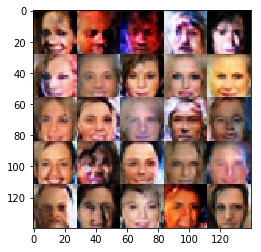

Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.9093
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 1.8115
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 0.5715... Generator Loss: 2.6312
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 1.0672


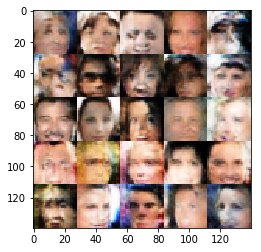

Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.2725
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.8263


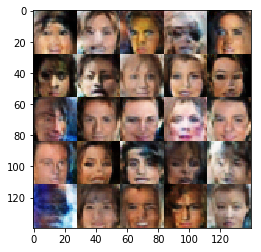

Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.1200
Epoch 1/1... Discriminator Loss: 1.7773... Generator Loss: 0.3268
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 1.7377
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 1.8620


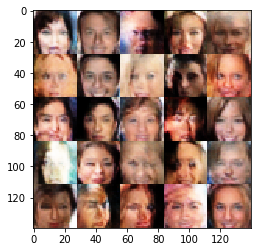

Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.3180
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.7720... Generator Loss: 2.3578
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 1.5824
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 2.0404
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.8440


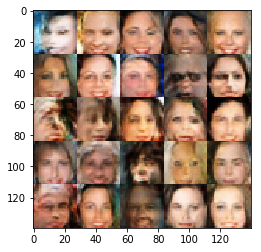

Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 1.5927
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.6849
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.4048
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.4199


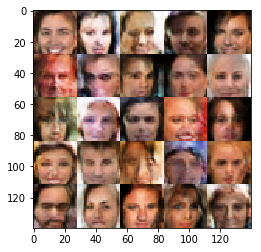

Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.7095... Generator Loss: 0.3411
Epoch 1/1... Discriminator Loss: 0.6657... Generator Loss: 1.8162
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.4333
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 2.1278
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 2.4577
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.5688
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.7101


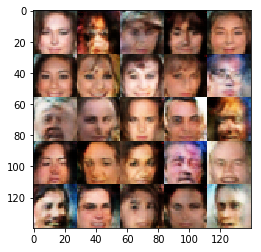

Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.7591... Generator Loss: 0.3126
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.4518
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 2.9872
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.8495
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.3230
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.0655


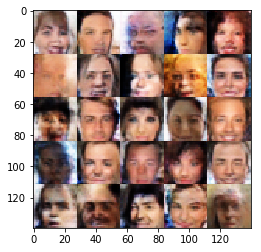

Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 1.1853
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.5017
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 0.9569


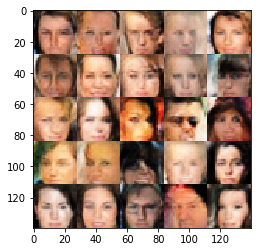

Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 1.2975
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.3469
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 1.0742


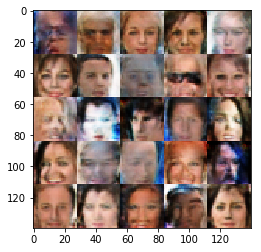

Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 1.2412
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 2.2128
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 1.1220
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 0.6497... Generator Loss: 2.1789
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 1.2062
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.3599


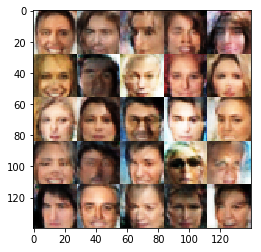

Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 1.2985
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.4145
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.3868


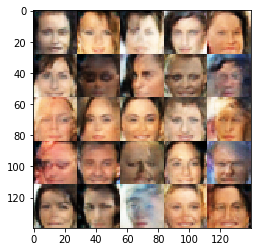

Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.1259
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.4853
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.7792


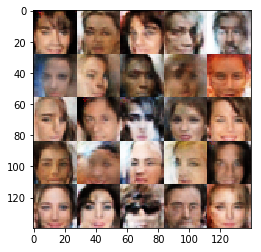

Epoch 1/1... Discriminator Loss: 1.5680... Generator Loss: 0.4011
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 1.4211
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.7214... Generator Loss: 0.4000
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.7215
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 0.9637


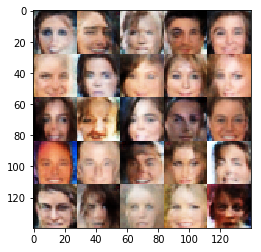

Epoch 1/1... Discriminator Loss: 1.6872... Generator Loss: 0.3505
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 2.0060
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.2638
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.3956


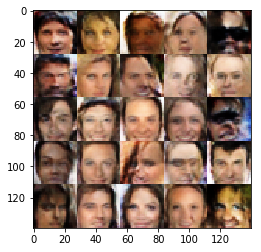

Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.0402
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.3976
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.4543
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.1395


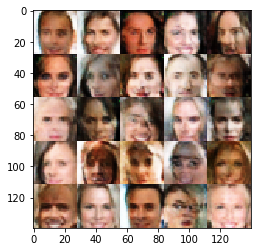

Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.4603
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.6061
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 1.2515
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 1.6028
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.5891


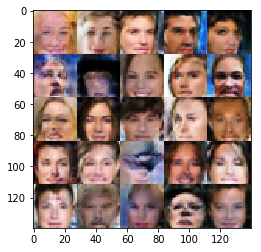

Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.9053


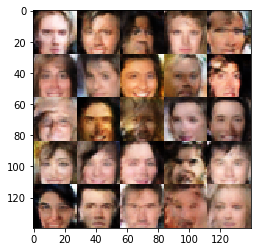

Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 1.0724
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.1877
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.8182


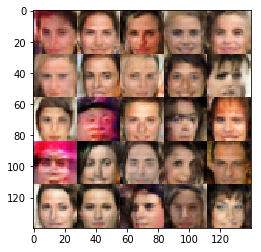

Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.2321
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 1.1675
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.4245
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 1.0516


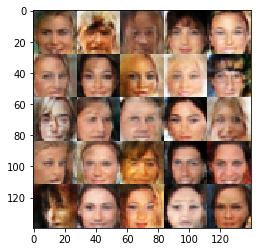

Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 1.5505
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 1.8093
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.5632


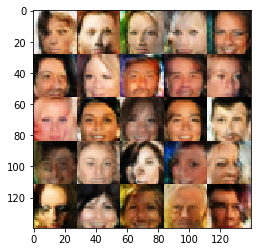

Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.6978... Generator Loss: 0.4064
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.4010
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.8758


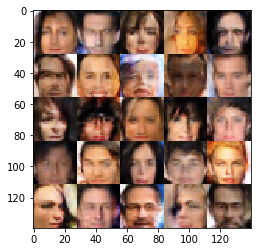

Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.4239
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 1.4370
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.6292


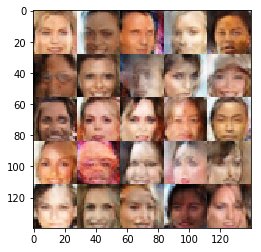

Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.7755


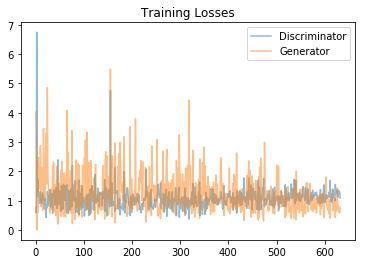

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.